In [ ]:
# Auther: Tzu-Han Hsu

# BSD 3-Clause License

# Copyright (c) 2022, Anywhere Door Lab (ADL) and Tzu-Han Hsu
# All rights reserved.

# Redistribution and use in source and binary forms, with or without
# modification, are permitted provided that the following conditions are met:

# 1. Redistributions of source code must retain the above copyright notice, this
#    list of conditions and the following disclaimer.

# 2. Redistributions in binary form must reproduce the above copyright notice,
#    this list of conditions and the following disclaimer in the documentation
#    and/or other materials provided with the distribution.

# 3. Neither the name of the copyright holder nor the names of its
#    contributors may be used to endorse or promote products derived from
#    this software without specific prior written permission.

# THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
# AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
# IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
# DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
# FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
# DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
# SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
# CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
# OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
# OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import torch
import torchvision 
import os
from torch.utils import data
from PIL import Image
import torchvision.datasets as dset
import numpy as np

import matplotlib.pyplot as plt
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from tqdm.notebook import tqdm
import torchvision.models as models
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import matplotlib.pyplot as plt
import pickle
from torchsummary import summary

#vital params

 
model_name="ResNet34"

dataset_name="caltech101"

#hyperparameters
batch_size=20
num_classes=-1
learning_rate=0.001
input_size=784
image_size=(224,224)


if dataset_name == "tsrd":
    num_classes=58
elif dataset_name == "cifar10":
    num_classes=10
elif dataset_name == "caltech101":
    num_classes=101
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Model: "+model_name +" with {} classes".format(num_classes)+
      " running on: "+dataset_name)


# load data through imagefolder
if dataset_name == "tsrd":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/data"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [5000, 998])
    train_set, test_set = data.random_split(train_set,[4000, 1000])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
elif dataset_name == "caltech101":
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.485, 0.456, 0.406] , std = [0.229, 0.224, 0.225]),

    ])

    train_dir = "../../dataset/caltech101"
    head_train_set = dset.ImageFolder(train_dir,transform=main_transforms)
    train_set, valid_set = data.random_split(head_train_set, [7477, 1200])
    train_set, test_set = data.random_split(train_set,[6277, 1200])


    train_dataloader=torch.utils.data.DataLoader(train_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    val_dataloader=torch.utils.data.DataLoader(valid_set,
                                                 batch_size=batch_size,
                                                 shuffle=True)

    test_dataloader=torch.utils.data.DataLoader(test_set,
                                                 batch_size=1,
                                                 shuffle=True)
    
    
elif dataset_name == "cifar10":
    
    main_transforms=transforms.Compose([
        transforms.Resize(image_size),
        transforms.ToTensor(),
        transforms.Normalize(mean = [0.5, 0.5, 0.5] , std = [0.5, 0.5, 0.5]),

    ])

    bigtrain_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=main_transforms)
    train_set, valid_set = data.random_split(bigtrain_set, [40000, 10000])
    test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=main_transforms)


    train_dataloader = torch.utils.data.DataLoader(train_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    val_dataloader = torch.utils.data.DataLoader(valid_set, 
                                                   batch_size=batch_size, 
                                                   shuffle=True, num_workers=2)

    test_dataloader = torch.utils.data.DataLoader(test_set,
                                                  batch_size=batch_size,
                                                  shuffle=False, num_workers=2)




print("Dataset size: Train: {}, Valid: {}, Test: {}"
      .format(len(train_set),len(valid_set),len(test_set)))

print(head_train_set.class_to_idx)
print(train_set[0][0].shape)
print("Datasets loaded and prepared")

Model: ResNet34 with 101 classes running on: caltech101
Dataset size: Train: 6277, Valid: 1200, Test: 1200
{'Faces': 0, 'Faces_easy': 1, 'Leopards': 2, 'Motorbikes': 3, 'accordion': 4, 'airplanes': 5, 'anchor': 6, 'ant': 7, 'barrel': 8, 'bass': 9, 'beaver': 10, 'binocular': 11, 'bonsai': 12, 'brain': 13, 'brontosaurus': 14, 'buddha': 15, 'butterfly': 16, 'camera': 17, 'cannon': 18, 'car_side': 19, 'ceiling_fan': 20, 'cellphone': 21, 'chair': 22, 'chandelier': 23, 'cougar_body': 24, 'cougar_face': 25, 'crab': 26, 'crayfish': 27, 'crocodile': 28, 'crocodile_head': 29, 'cup': 30, 'dalmatian': 31, 'dollar_bill': 32, 'dolphin': 33, 'dragonfly': 34, 'electric_guitar': 35, 'elephant': 36, 'emu': 37, 'euphonium': 38, 'ewer': 39, 'ferry': 40, 'flamingo': 41, 'flamingo_head': 42, 'garfield': 43, 'gerenuk': 44, 'gramophone': 45, 'grand_piano': 46, 'hawksbill': 47, 'headphone': 48, 'hedgehog': 49, 'helicopter': 50, 'ibis': 51, 'inline_skate': 52, 'joshua_tree': 53, 'kangaroo': 54, 'ketch': 55, 'la

In [2]:
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

class BasicBlock(nn.Module):
    expansion = 1
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class Bottleneck(nn.Module):
    expansion = 4
 
    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride,
                               padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * self.expansion, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride
 
    def forward(self, x):
        residual = x
 
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
 
        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)
 
        out = self.conv3(out)
        out = self.bn3(out)
 
        if self.downsample is not None:
            residual = self.downsample(x)
 
        out += residual
        out = self.relu(out)
 
        return out
class ResNet(nn.Module):
 
    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 64
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512 * block.expansion, num_classes)
 
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
 
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )
 
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))
 
        return nn.Sequential(*layers)
 
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)
 
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
 
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
 
        return x

def resnet18(pretrained=False, **kwargs):
    """Constructs a ResNet-18 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model
 
 
def resnet34(pretrained=False, **kwargs):
    """Constructs a ResNet-34 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(BasicBlock, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet34']))
    return model
 
 
def resnet50(pretrained=False, **kwargs):
    """Constructs a ResNet-50 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 6, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet50']))
    return model
 
 
def resnet101(pretrained=False, **kwargs):
    """Constructs a ResNet-101 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet101']))
    return model
 
 
def resnet152(pretrained=False, **kwargs):
    """Constructs a ResNet-152 model.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
    """
    model = ResNet(Bottleneck, [3, 8, 36, 3], **kwargs)
    if pretrained:
        model.load_state_dict(model_zoo.load_url(model_urls['resnet152']))
    return model

In [3]:
model = resnet34()
model.fc=nn.Linear(512,num_classes)
model = model.to(device)

from thop import profile
import colorama
from colorama import Fore,Style
#vital params
def getGFLOPS(test_model):
    model=test_model.to(device)
    input = torch.randn(1, 3, 224, 224).to(device)
    macs, params = profile(model, inputs=(input, ))

    print(Fore.BLUE + "The model requires: {:.4f} GFLOPS".format(macs/1000_000_000))
    print(Style.RESET_ALL)
    return macs
getGFLOPS(model)
#pretesting model for shape
x=torch.randn(batch_size,3,224,224)
x=x.to(device)
print(x.shape)
print(model(x).shape)
print("model shape ready")
print(summary(model, input_size=(3, 224, 224)))
#initailise network


#loss and optimizer
criterion=nn.CrossEntropyLoss()
optimizer=optim.Adam(model.parameters(),lr=learning_rate)
print("model initialised")

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_bn() for <class 'torch.nn.modules.batchnorm.BatchNorm2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.activation.ReLU'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.pooling.MaxPool2d'>.
[WARN] Cannot find rule for <class '__main__.BasicBlock'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class '__main__.ResNet'>. Treat it as zero Macs and zero Params.
The model requires: 3.6708 GFLOPS

torch.Size([20, 3, 224, 224])
torch.Size([20, 101])
model shape ready
----------------------------------------------------------------
        Layer (type)               Output Shape        

In [4]:
# This is the testing part
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp
get_n_params(model)

def test(model, test_loader, istest= False, doprint=True):
    model.eval()
    test_loss = 0
    correct = 0
    TP=0
    TN=0
    FN=0
    FP=0
    test_loss = 0.0
    
    with torch.no_grad(): # disable gradient calculation for efficiency
        for data, target in tqdm(test_loader):
            # Prediction
            data=data.to(device=device)
            target=target.to(device=device)
            optimizer.zero_grad()
            
            output = model(data)
            loss=criterion(output,target)
            
            # Compute loss & accuracy
            test_loss+=loss.item()*data.size(0)

            
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in this batch are correct
            
            #print("pred={} , target={} , judge={}".format(pred.item(),target.item(),pred.eq(target.view_as(pred)).sum().item()))

            
    #test_loss /= len(test_loader.dataset)

        
    # Log testing info
    if istest and doprint:
        
        print('Loss: {}   Accuracy: {}/{} ({:.3f}%)'.format(test_loss,
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
        print("Total parameters: {}".format(get_n_params(model)))
    elif doprint:
        print('Accuracy: {}/{} ({:.3f}%)'.format(
        correct, len(test_loader.dataset),
        100.000 * correct / len(test_loader.dataset)))
    return 100.000 * correct / len(test_loader.dataset)
        

print("test defined")

def testshouldearlystop(acclist,minepoch,epochwindow,accwindow):
    runlen=len(acclist)
    if(runlen<minepoch):
        return False
    elif(acclist[-1]>acclist[-2]):
        return False
    
    watchwindow=acclist[-epochwindow:]
    shouldjump=True
    sum=0
    for i in watchwindow:
        sum+=i
    avg = sum/epochwindow
    for i in watchwindow:
        if abs(i-avg)>(accwindow):
            shouldjump=False
    return shouldjump
print("early stop defined")

test defined
early stop defined


In [5]:
now=datetime.now()
dt_string = now.strftime("%Y%m%d%H%M%S")

tensorboard_string="runs/"+"/"+model_name+dt_string
grandstore_string="grandstore/"+dataset_name+"_"+model_name+dt_string+".pkl"
print("tensorboard_string:")
print(tensorboard_string)
print("grandstore_string")
print(grandstore_string)


writer = SummaryWriter(tensorboard_string)


tensorboard_string:
runs//ResNet3420211221111939
grandstore_string
grandstore/caltech101_ResNet3420211221111939.pkl


In [6]:
#This is the training part

# Grand_store={
#     'total_epoch_run':-1
#     'topmodels':-1
#     'lastmodel':-1
#     'acclog':[]
#     'maxacc':-1
#     'minacc':101
# }
# train_epoch={
#     "numofepoch":-1
#     "accuracy":-1
#     "model_state":model.state_dict(),
#     "optim_state":optimizer.state_dict(),
#     "totaltrain_loss":totaltrain_loss,
#     "totalvalid_loss":totalvalid_loss
# }

def training(max_epoch=120, top_accuracy_track=3, grandstore={},
             minepoch=30,epochwindow=10,accwindow=0.35):

    grandstore['total_epoch_run']=0
    grandstore['topmodels']=[]
    grandstore['acclog']=[]
    grandstore['maxacc']=-1
    grandstore['minacc']=101
    
    for epoch in range(0,max_epoch):
        
        grandstore['total_epoch_run']=epoch+1
        
        train_epoch={
        "numofepoch":grandstore['total_epoch_run']
        }
    
        train_loss=0.0
        valid_loss=0.0
        print("Running epoch: {}".format(epoch+1))

        model.train()
        totaltrain_loss=0
        
        #this is the training part
        for data,target in tqdm(train_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output = model(data)
            loss = criterion(output, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()*data.size(0)
            totaltrain_loss += train_loss

        #this is the validation part
        model.eval()
        totalvalid_loss=0;
        correct = 0
        for data,target in tqdm(val_dataloader):
            data=data.to(device=device)
            target=target.to(device=device)
            output=model(data)
            loss=criterion(output,target)
            valid_loss=loss.item()*data.size(0)
            #train_loss = train_loss/len(train_dataloader.dataset)
            #valid_loss = valid_loss/len(val_dataloader.dataset)
            totalvalid_loss+=valid_loss
            
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item() # how many predictions in t
        

        training_accuracy=100. * correct / len(val_dataloader.dataset)
        train_epoch["accuracy"]=training_accuracy
        train_epoch["totaltrain_loss"]=totaltrain_loss
        train_epoch["totalvalid_loss"]=totalvalid_loss
        
        #writings to the GrandStore
        
        grandstore['acclog'].append(training_accuracy)
        
        if training_accuracy < grandstore['minacc']:
            grandstore['minacc'] = training_accuracy
            
        if training_accuracy > grandstore['maxacc']:
            grandstore['maxacc'] = training_accuracy
        

        if epoch < top_accuracy_track:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'].append((training_accuracy,thisepochtestresult,epoch+1,train_epoch))
            #if error print this
            grandstore['topmodels'].sort()

        elif training_accuracy > grandstore['topmodels'][0][0]:
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['topmodels'][0]=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            #if error print this
            grandstore['topmodels'].sort()

        if epoch == (max_epoch-1):
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
                     
        writer.add_scalar('Training Loss',totaltrain_loss,global_step = epoch)
        writer.add_scalar('Valid Loss',totalvalid_loss,global_step = epoch)
        writer.add_scalar('Accuracy',training_accuracy,global_step = epoch)
        
        print('Accuracy: {:.3f}'.format(training_accuracy))
        print('Training Loss: {:.4f} \tValidation Loss: {:.4f}\n'.format(totaltrain_loss, totalvalid_loss))
        
        #early stopping criteria
        if(testshouldearlystop(acclist=grandstore['acclog'],
                               minepoch = minepoch,
                               epochwindow = epochwindow,
                               accwindow = accwindow)):
            print("early stop occured!!")
            thisepochtestresult=test(model,test_dataloader,istest = True,doprint=False)
            grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)
            return grandstore
    
    return grandstore
        


In [7]:
TOP_ACCURACY_TRACK = 5
# max_epoch=120, top_accuracy_track=3, grandstore={},
# minepoch=30,epochwindow=10,accwindow=0.35

Grandstore=training(max_epoch=200,
                    minepoch=120,
                    top_accuracy_track=TOP_ACCURACY_TRACK,
                    epochwindow=10,
                    accwindow=0.25                 
                   )

Running epoch: 1


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 21.000
Training Loss: 3923350.9364 	Validation Loss: 5493.8337

Running epoch: 2


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 34.667
Training Loss: 3234155.4723 	Validation Loss: 3623.2110

Running epoch: 3


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 42.333
Training Loss: 2941722.5897 	Validation Loss: 3212.5372

Running epoch: 4


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 45.333
Training Loss: 2557977.5414 	Validation Loss: 2831.0939

Running epoch: 5


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 49.250
Training Loss: 2167221.3667 	Validation Loss: 2591.0171

Running epoch: 6


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 56.417
Training Loss: 1844403.3838 	Validation Loss: 2195.5751

Running epoch: 7


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 58.333
Training Loss: 1504665.5826 	Validation Loss: 2029.2434

Running epoch: 8


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.500
Training Loss: 1280589.5673 	Validation Loss: 1797.1038

Running epoch: 9


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 63.500
Training Loss: 1002999.1397 	Validation Loss: 1871.4604

Running epoch: 10


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 64.083
Training Loss: 782720.5821 	Validation Loss: 1746.6760

Running epoch: 11


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 62.417
Training Loss: 594179.9620 	Validation Loss: 1923.8715

Running epoch: 12


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 67.500
Training Loss: 458822.9689 	Validation Loss: 1757.3355

Running epoch: 13


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 326934.5033 	Validation Loss: 1707.4161

Running epoch: 14


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.000
Training Loss: 241370.2283 	Validation Loss: 1714.6725

Running epoch: 15


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 68.500
Training Loss: 170487.0515 	Validation Loss: 1851.4822

Running epoch: 16


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 108032.5599 	Validation Loss: 1802.1175

Running epoch: 17


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 120566.3328 	Validation Loss: 1685.5318

Running epoch: 18


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 69.250
Training Loss: 69519.2986 	Validation Loss: 1887.3523

Running epoch: 19


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 67.833
Training Loss: 115514.9677 	Validation Loss: 2135.1958

Running epoch: 20


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.583
Training Loss: 163483.5528 	Validation Loss: 1893.2300

Running epoch: 21


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 71061.6161 	Validation Loss: 1788.8654

Running epoch: 22


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 57635.5279 	Validation Loss: 1763.5824

Running epoch: 23


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 71898.2620 	Validation Loss: 2082.4986

Running epoch: 24


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 65.750
Training Loss: 94482.7228 	Validation Loss: 2514.6146

Running epoch: 25


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 95881.8882 	Validation Loss: 1821.9979

Running epoch: 26


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 32179.3747 	Validation Loss: 1786.8502

Running epoch: 27


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 71.667
Training Loss: 24276.1816 	Validation Loss: 1933.2258

Running epoch: 28


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 68.583
Training Loss: 93580.8271 	Validation Loss: 2436.5821

Running epoch: 29


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 105602.3414 	Validation Loss: 1875.2090

Running epoch: 30


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 37355.6662 	Validation Loss: 1982.0344

Running epoch: 31


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 29838.1999 	Validation Loss: 2003.7921

Running epoch: 32


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 71477.0809 	Validation Loss: 2268.8269

Running epoch: 33


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 79128.7003 	Validation Loss: 1936.4042

Running epoch: 34


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 28332.4121 	Validation Loss: 1857.3373

Running epoch: 35


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 68.750
Training Loss: 46906.9275 	Validation Loss: 2389.1029

Running epoch: 36


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 66461.2097 	Validation Loss: 1949.2867

Running epoch: 37


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 38247.0224 	Validation Loss: 2340.9895

Running epoch: 38


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 41860.3516 	Validation Loss: 1850.0215

Running epoch: 39


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 22533.2549 	Validation Loss: 1878.3125

Running epoch: 40


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.500
Training Loss: 20384.0519 	Validation Loss: 2087.0637

Running epoch: 41


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 75575.5286 	Validation Loss: 2296.6123

Running epoch: 42


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 72865.7834 	Validation Loss: 2246.9296

Running epoch: 43


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 28385.3510 	Validation Loss: 1876.9682

Running epoch: 44


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 10827.3936 	Validation Loss: 1951.9562

Running epoch: 45


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.333
Training Loss: 23265.3675 	Validation Loss: 2058.3210

Running epoch: 46


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 19815.8917 	Validation Loss: 2097.7584

Running epoch: 47


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 69.500
Training Loss: 40289.6921 	Validation Loss: 2420.8710

Running epoch: 48


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 88615.3316 	Validation Loss: 1914.9754

Running epoch: 49


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 11649.3751 	Validation Loss: 1882.1518

Running epoch: 50


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 8046.7806 	Validation Loss: 1967.2623

Running epoch: 51


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 20812.4290 	Validation Loss: 2173.1087

Running epoch: 52


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 67.667
Training Loss: 35703.7953 	Validation Loss: 2627.1252

Running epoch: 53


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 71160.4865 	Validation Loss: 2050.0340

Running epoch: 54


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 15937.7251 	Validation Loss: 2264.4986

Running epoch: 55


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 17646.4257 	Validation Loss: 2111.6850

Running epoch: 56


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.000
Training Loss: 31729.7415 	Validation Loss: 2268.4931

Running epoch: 57


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 49083.9411 	Validation Loss: 2001.1114

Running epoch: 58


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 10092.4978 	Validation Loss: 2089.7098

Running epoch: 59


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.417
Training Loss: 8015.6929 	Validation Loss: 2227.7878

Running epoch: 60


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 70.750
Training Loss: 42794.3663 	Validation Loss: 2300.1222

Running epoch: 61


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 28545.9118 	Validation Loss: 2038.7783

Running epoch: 62


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 5800.4530 	Validation Loss: 1999.3391

Running epoch: 63


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 1898.0305 	Validation Loss: 1924.8794

Running epoch: 64


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 3566.4915 	Validation Loss: 1834.2088

Running epoch: 65


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 1627.8958 	Validation Loss: 1829.5569

Running epoch: 66


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 1611.1932 	Validation Loss: 1837.3156

Running epoch: 67


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 736.2723 	Validation Loss: 1809.0469

Running epoch: 68


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 997.4610 	Validation Loss: 1827.8915

Running epoch: 69


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 798.7075 	Validation Loss: 1860.6092

Running epoch: 70


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 1778.9733 	Validation Loss: 1909.1149

Running epoch: 71


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 1096.2981 	Validation Loss: 1911.7103

Running epoch: 72


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 1907.9675 	Validation Loss: 1849.0868

Running epoch: 73


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 110264.8489 	Validation Loss: 2010.6370

Running epoch: 74


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.417
Training Loss: 48083.0480 	Validation Loss: 1870.4163

Running epoch: 75


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 13639.7755 	Validation Loss: 1841.1139

Running epoch: 76


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 8870.2732 	Validation Loss: 1863.3662

Running epoch: 77


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 4435.3303 	Validation Loss: 1775.8086

Running epoch: 78


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 2254.5495 	Validation Loss: 1705.2713

Running epoch: 79


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 2099.0652 	Validation Loss: 1826.0011

Running epoch: 80


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 70.417
Training Loss: 32889.4354 	Validation Loss: 2200.3484

Running epoch: 81


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 51952.8297 	Validation Loss: 2200.6490

Running epoch: 82


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.167
Training Loss: 12953.9748 	Validation Loss: 1923.2120

Running epoch: 83


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.917
Training Loss: 5599.8496 	Validation Loss: 2217.3337

Running epoch: 84


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.333
Training Loss: 16837.2088 	Validation Loss: 2246.1177

Running epoch: 85


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.167
Training Loss: 17347.7098 	Validation Loss: 2179.9842

Running epoch: 86


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 19468.5911 	Validation Loss: 2047.4398

Running epoch: 87


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 4884.8682 	Validation Loss: 2047.5623

Running epoch: 88


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 37961.9338 	Validation Loss: 2320.6464

Running epoch: 89


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.583
Training Loss: 22872.7031 	Validation Loss: 2140.8677

Running epoch: 90


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 19674.1884 	Validation Loss: 2048.0349

Running epoch: 91


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 8450.0893 	Validation Loss: 2165.1713

Running epoch: 92


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 2459.0527 	Validation Loss: 2033.8072

Running epoch: 93


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 623.9424 	Validation Loss: 1979.0034

Running epoch: 94


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 1518.2001 	Validation Loss: 2030.7869

Running epoch: 95


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 1069.8498 	Validation Loss: 2076.2225

Running epoch: 96


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 59.083
Training Loss: 5344.3893 	Validation Loss: 4333.7000

Running epoch: 97


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.167
Training Loss: 153663.0555 	Validation Loss: 1942.4126

Running epoch: 98


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 6897.7399 	Validation Loss: 1849.6914

Running epoch: 99


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 4344.3281 	Validation Loss: 1822.3322

Running epoch: 100


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 4225.9351 	Validation Loss: 1748.2752

Running epoch: 101


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.917
Training Loss: 1888.2755 	Validation Loss: 1740.2626

Running epoch: 102


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 6375.6965 	Validation Loss: 1875.3719

Running epoch: 103


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 6400.7948 	Validation Loss: 1947.6253

Running epoch: 104


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 2841.7912 	Validation Loss: 1862.9828

Running epoch: 105


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 1581.3757 	Validation Loss: 1834.2546

Running epoch: 106


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 1077.7924 	Validation Loss: 1816.2229

Running epoch: 107


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 902.4758 	Validation Loss: 1895.4482

Running epoch: 108


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 65.083
Training Loss: 8915.4343 	Validation Loss: 3093.6152

Running epoch: 109


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.750
Training Loss: 118682.6470 	Validation Loss: 2289.1472

Running epoch: 110


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 21238.4141 	Validation Loss: 1918.5441

Running epoch: 111


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 4466.5343 	Validation Loss: 1913.3129

Running epoch: 112


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.583
Training Loss: 1697.2388 	Validation Loss: 1816.4645

Running epoch: 113


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 1427.4113 	Validation Loss: 1893.7286

Running epoch: 114


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 1531.0801 	Validation Loss: 2190.2409

Running epoch: 115


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.417
Training Loss: 28416.4050 	Validation Loss: 2314.5921

Running epoch: 116


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 17741.4856 	Validation Loss: 2159.6273

Running epoch: 117


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 16059.3210 	Validation Loss: 2080.9874

Running epoch: 118


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.750
Training Loss: 4955.6005 	Validation Loss: 2129.4095

Running epoch: 119


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.750
Training Loss: 11141.5651 	Validation Loss: 2239.2736

Running epoch: 120


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 15265.2477 	Validation Loss: 2131.7975

Running epoch: 121


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 7379.0966 	Validation Loss: 2144.8636

Running epoch: 122


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.250
Training Loss: 2562.9286 	Validation Loss: 2007.8207

Running epoch: 123


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.167
Training Loss: 5390.5404 	Validation Loss: 2387.4101

Running epoch: 124


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.667
Training Loss: 12148.9607 	Validation Loss: 2419.5747

Running epoch: 125


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 29026.1560 	Validation Loss: 2375.4743

Running epoch: 126


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 14967.7998 	Validation Loss: 2089.8814

Running epoch: 127


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 4307.3941 	Validation Loss: 1965.8187

Running epoch: 128


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 1339.5702 	Validation Loss: 1968.5436

Running epoch: 129


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 2399.2023 	Validation Loss: 2170.7658

Running epoch: 130


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 70.917
Training Loss: 12366.5162 	Validation Loss: 2397.7274

Running epoch: 131


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 23748.3974 	Validation Loss: 2408.6062

Running epoch: 132


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 16754.0748 	Validation Loss: 2267.3825

Running epoch: 133


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 13220.9509 	Validation Loss: 2043.3923

Running epoch: 134


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 2722.8169 	Validation Loss: 1925.4185

Running epoch: 135


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 2905.9300 	Validation Loss: 1963.7525

Running epoch: 136


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.417
Training Loss: 1377.3260 	Validation Loss: 1926.2221

Running epoch: 137


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 2834.3613 	Validation Loss: 2031.9357

Running epoch: 138


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 20050.5228 	Validation Loss: 2379.7895

Running epoch: 139


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 26508.3086 	Validation Loss: 2091.5895

Running epoch: 140


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 6347.3267 	Validation Loss: 2110.7345

Running epoch: 141


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 4341.1104 	Validation Loss: 2134.4708

Running epoch: 142


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.667
Training Loss: 5885.0297 	Validation Loss: 1941.2748

Running epoch: 143


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 2531.1660 	Validation Loss: 2016.1540

Running epoch: 144


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.833
Training Loss: 1382.7566 	Validation Loss: 1992.2447

Running epoch: 145


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.083
Training Loss: 1992.9085 	Validation Loss: 2276.3539

Running epoch: 146


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.833
Training Loss: 35909.1091 	Validation Loss: 2346.0133

Running epoch: 147


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 12922.8640 	Validation Loss: 1963.2536

Running epoch: 148


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 8053.1001 	Validation Loss: 2080.2398

Running epoch: 149


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.583
Training Loss: 9386.5893 	Validation Loss: 2138.1433

Running epoch: 150


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.000
Training Loss: 7294.4066 	Validation Loss: 2307.9116

Running epoch: 151


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.250
Training Loss: 14627.7664 	Validation Loss: 2166.4537

Running epoch: 152


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.833
Training Loss: 7463.9719 	Validation Loss: 2070.6106

Running epoch: 153


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 6498.6368 	Validation Loss: 2143.3083

Running epoch: 154


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 6204.4458 	Validation Loss: 2013.9595

Running epoch: 155


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.500
Training Loss: 4160.5008 	Validation Loss: 2418.8078

Running epoch: 156


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.333
Training Loss: 23647.4990 	Validation Loss: 2216.7902

Running epoch: 157


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 9435.9046 	Validation Loss: 2114.6857

Running epoch: 158


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.083
Training Loss: 7660.6770 	Validation Loss: 2078.6156

Running epoch: 159


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.583
Training Loss: 2423.4487 	Validation Loss: 2067.3565

Running epoch: 160


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.167
Training Loss: 1462.3350 	Validation Loss: 2081.4506

Running epoch: 161


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 1318.0885 	Validation Loss: 2080.7985

Running epoch: 162


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 1347.3338 	Validation Loss: 2226.4189

Running epoch: 163


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.000
Training Loss: 31366.4482 	Validation Loss: 2233.0409

Running epoch: 164


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.000
Training Loss: 17435.1822 	Validation Loss: 2056.4689

Running epoch: 165


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.000
Training Loss: 2690.6760 	Validation Loss: 2109.2817

Running epoch: 166


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.667
Training Loss: 1434.1897 	Validation Loss: 2009.2221

Running epoch: 167


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.750
Training Loss: 7071.9438 	Validation Loss: 2040.3003

Running epoch: 168


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.083
Training Loss: 18666.3264 	Validation Loss: 2174.3805

Running epoch: 169


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 13481.9702 	Validation Loss: 2066.1951

Running epoch: 170


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.417
Training Loss: 3378.7228 	Validation Loss: 1960.3100

Running epoch: 171


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.917
Training Loss: 1275.4908 	Validation Loss: 1927.0945

Running epoch: 172


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 1083.8775 	Validation Loss: 2015.5238

Running epoch: 173


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 2904.5465 	Validation Loss: 2140.0718

Running epoch: 174


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 71.333
Training Loss: 13019.0726 	Validation Loss: 2652.7930

Running epoch: 175


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.083
Training Loss: 14206.0408 	Validation Loss: 2462.8984

Running epoch: 176


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.667
Training Loss: 9677.9932 	Validation Loss: 2208.1828

Running epoch: 177


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 76.000
Training Loss: 5124.2171 	Validation Loss: 2022.9222

Running epoch: 178


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 2027.8253 	Validation Loss: 2033.6596

Running epoch: 179


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.500
Training Loss: 1981.8700 	Validation Loss: 2129.4170

Running epoch: 180


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.417
Training Loss: 13088.0991 	Validation Loss: 2003.9191

Running epoch: 181


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 3649.6779 	Validation Loss: 2131.4616

Running epoch: 182


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 72.250
Training Loss: 10316.1979 	Validation Loss: 2448.5776

Running epoch: 183


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.500
Training Loss: 8815.1447 	Validation Loss: 2224.6208

Running epoch: 184


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 5313.7601 	Validation Loss: 2096.2297

Running epoch: 185


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.250
Training Loss: 2472.8622 	Validation Loss: 2145.4112

Running epoch: 186


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 73.917
Training Loss: 7999.4402 	Validation Loss: 2328.9453

Running epoch: 187


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 74.833
Training Loss: 5451.3343 	Validation Loss: 2073.2653

Running epoch: 188


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 1863.3638 	Validation Loss: 1951.0891

Running epoch: 189


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 1293.7269 	Validation Loss: 2019.0974

Running epoch: 190


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.917
Training Loss: 1181.9417 	Validation Loss: 2008.8534

Running epoch: 191


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.333
Training Loss: 1717.7547 	Validation Loss: 2096.3943

Running epoch: 192


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.500
Training Loss: 891.6262 	Validation Loss: 2077.0281

Running epoch: 193


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 75.750
Training Loss: 611.4382 	Validation Loss: 2099.3933

Running epoch: 194


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.333
Training Loss: 1250.7599 	Validation Loss: 2044.7401

Running epoch: 195


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 76.083
Training Loss: 927.1001 	Validation Loss: 2025.1004

Running epoch: 196


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.750
Training Loss: 1136.7202 	Validation Loss: 1984.5241

Running epoch: 197


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

Accuracy: 76.167
Training Loss: 1026.7272 	Validation Loss: 1976.9935

Running epoch: 198


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 77.250
Training Loss: 851.1893 	Validation Loss: 2034.8359

Running epoch: 199


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 76.500
Training Loss: 1188.4590 	Validation Loss: 1999.8033

Running epoch: 200


  0%|          | 0/314 [00:00<?, ?it/s]

  0%|          | 0/60 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

Accuracy: 66.667
Training Loss: 8467.8230 	Validation Loss: 3102.1929



Model of: ResNet34 running on: caltech101

Total Run 200 epoch(s)
Accuracy MIN: 21.0 / MAX: 77.25

Top 5 performing epochs:
#1 epoch 198	||train_acc 77.25%	||test 76.33%
#2 epoch 101	||train_acc 76.92%	||test 76.58%
#3 epoch 196	||train_acc 76.75%	||test 76.25%
#4 epoch 199	||train_acc 76.50%	||test 77.00%
#5 epoch 136	||train_acc 76.42%	||test 74.00%

Last epoch:
epoch 200	||train_acc 66.67%	||test 65.58%

The model has parameters: 21336485


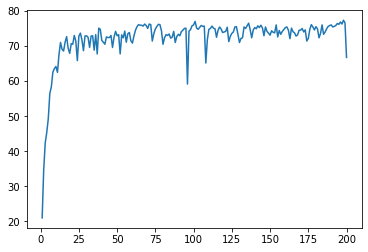

In [9]:
print("Model of: "+model_name +
      " running on: "+dataset_name+"\n")

print("Total Run {} epoch(s)".format(Grandstore['total_epoch_run']))

plt.plot(*[range(1,Grandstore['total_epoch_run']+1)],Grandstore['acclog'])
print("Accuracy MIN: {} / MAX: {}".format(Grandstore['minacc'],Grandstore['maxacc']))
print()
print("Top {} performing epochs:".format(TOP_ACCURACY_TRACK))


gstm=Grandstore['topmodels']
for i in range(TOP_ACCURACY_TRACK):
    easy=gstm[TOP_ACCURACY_TRACK-i-1]
    print("#{} epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(i+1,easy[2],easy[0],easy[1]))
print()
print("Last epoch:")
lsmd=Grandstore['lastmodel']
print("epoch {}\t||train_acc {:.2f}%\t||test {:.2f}%".format(Grandstore['total_epoch_run'],lsmd[0],lsmd[1]))
      
print()
print("The model has parameters: {}".format(get_n_params(model)))
#grandstore['lastmodel']=((training_accuracy,train_epoch,thisepochtestresult))
# grandstore['lastmodel']=(training_accuracy,thisepochtestresult,epoch+1,train_epoch)

In [10]:
  
f1=open(grandstore_string,"wb")
pickle.dump(Grandstore,f1)
f1.close()
# with open(grandstore_string, 'rb') as file:
#     myvar = pickle.load(file)
#     print(myvar)